In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import numpy.random as rnd
from PIL import Image

from antenna_utils import *

# plt.rcParams['image.cmap'] = 'cubehelix'
plt.rcParams['image.cmap'] = 'afmhot'

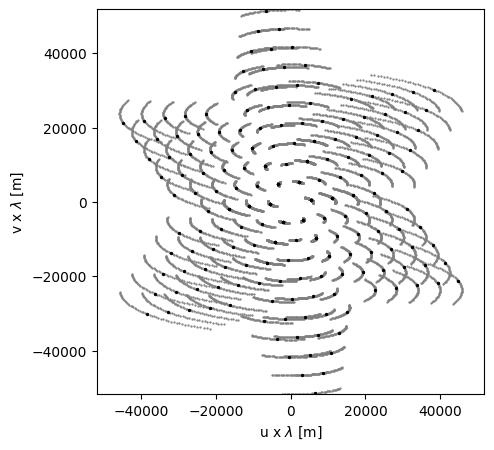

In [147]:
# Antenna parameters
x_lim = 30000
y_lim = 30000
n_antenna = 3*5
n_baselines = n_antenna*(n_antenna-1)
radius = 30000
alpha = 120

# Source tracking parameters
source_decl = 15/180*np.pi
array_lat = 19.1/180*np.pi
track_time = 4
delta_t = 5/60 # 300 segs
t_0 = -0.5

# Sky model
sky_models_folder = '../sky_models/'
sky_model = 'crux.png'
sky_model_path = sky_models_folder + sky_model
sky = load_sky_model(sky_model_path)

# UV parameters
uv_dim = sky.shape[0]

# Array
# arr = random_antenna_arr(n_antenna, x_lim, y_lim)
# arr = radial_antenna_arr(n_antenna, x_lim, y_lim,radius)
arr = y_antenna_arr(int(n_antenna/3), radius, alpha)
# Get baselines
base_arr = get_baselines(arr)
# Get time integrated uv samples
track = uv_time_int(base_arr, array_lat, source_decl, track_time, delta_t, t_0)
# Get uv mask
uv_plane = get_uv_plane(track,uv_dim)
uv_plane_mask = get_uv_mask(uv_plane)
# Get the dirty beam
beam = get_beam(uv_plane_mask)
# Get the sky model FT
sky_uv = get_sky_uv(sky)
# Sample Fourier space
obs_uv = get_obs_uv(sky_uv,uv_plane_mask)
# Get observed sky
obs_sky = get_obs_sky(obs_uv, abs=True)
# Add noise
sigma = 0.1
obs_sky += np.random.randn(obs_sky.shape[0],obs_sky.shape[1])*sigma

plot_uv_plane(track, n_baselines)

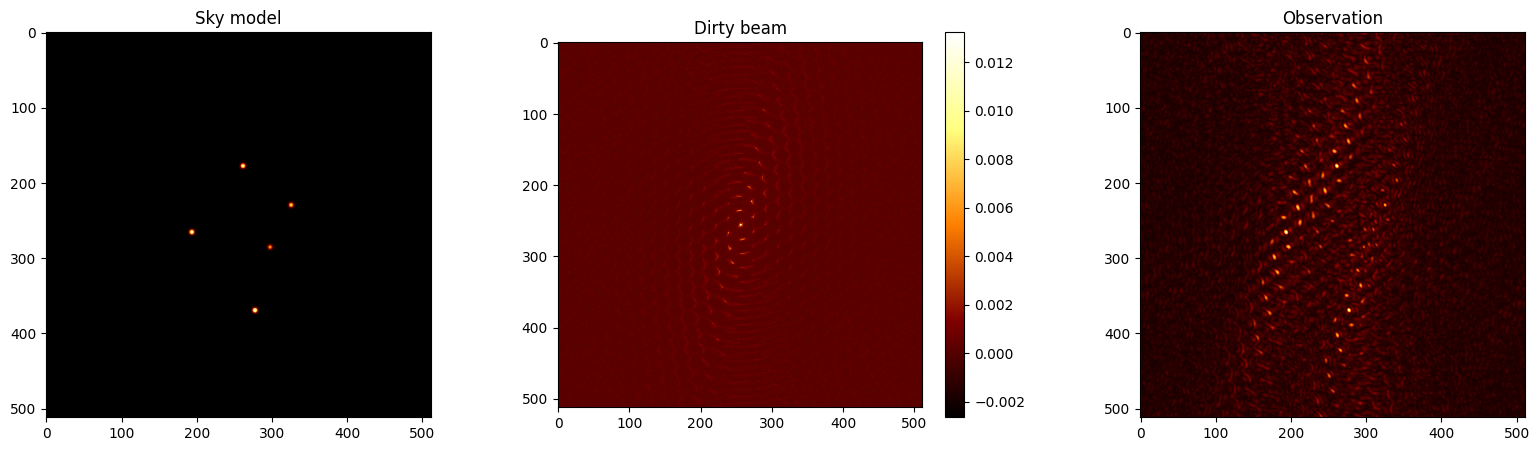

In [148]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].imshow(sky)
plot_beam(beam, ax=ax[1],fig=fig)
ax[2].imshow(obs_sky)

ax[0].set_title('Sky model')
ax[1].set_title('Dirty beam')
ax[2].set_title('Observation')
plt.show()

In [149]:
def shift_beam(beam, shift_x, shift_y):
    beam_shift = np.roll(beam,shift_x,axis=1)
    if shift_x<0:
        beam_shift[:,shift_x:] = 0
    else:
        beam_shift[:,:shift_x] = 0

    beam_shift = np.roll(beam_shift,shift_y,axis=0)
    if shift_y<0:
        beam_shift[shift_y:,:] = 0
    else:
        beam_shift[:shift_y,:] = 0
    return beam_shift

def find_peak(I):
    y_max, x_max = int(np.argmax(I)/I.shape[0]), np.mod(np.argmax(I),I.shape[0])
    x_off, y_off = int(I.shape[0]/2), int(I.shape[1]/2)
    shift_x, shift_y = x_max-x_off,y_max-y_off
    max_val = np.max(I)
    return max_val, x_max, y_max, shift_x, shift_y

def clean_beam(B, search_box=20):
    max_val, x_max, y_max, shift_x, shift_y = find_peak(B)
    B_clean = B[y_max-search_box:y_max+search_box,x_max-search_box:x_max+search_box]
    B_clean = np.pad(B_clean,((y_max-search_box,B.shape[0]-y_max-search_box),(x_max-search_box,B.shape[1]-x_max-search_box)))
    return B_clean

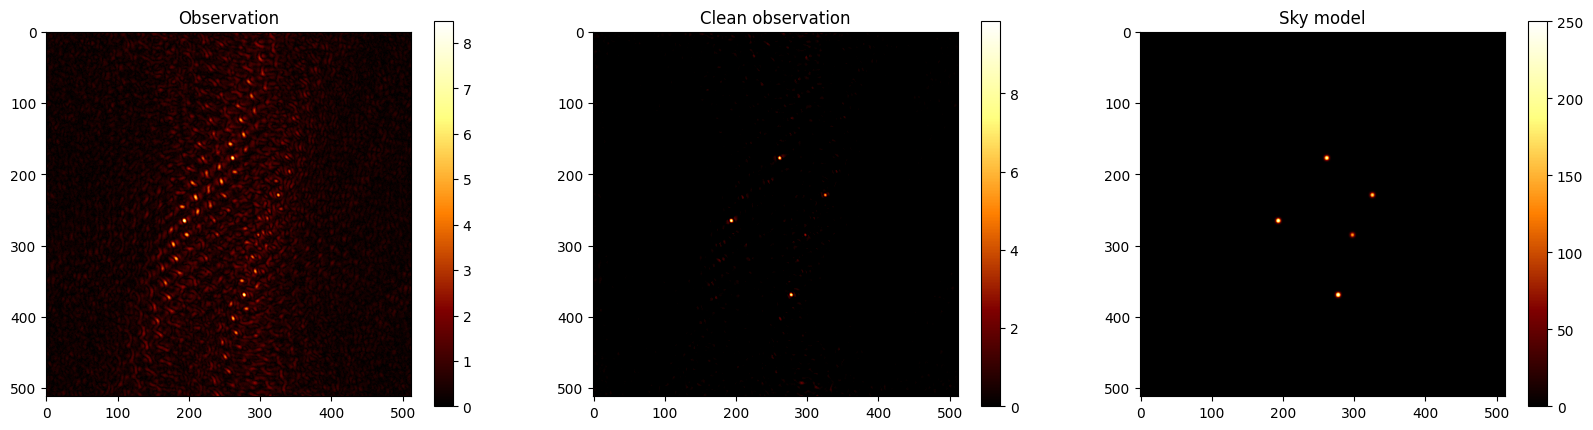

In [150]:
# Clean hyperparams
max_it = 100
treshold = 0.5
clean_gamma = 0.7
search_box = 10


# Clean initialisation
i=0
X=np.zeros(sky.shape)
Y=obs_sky.copy()
B_norm = np.fft.ifftshift(beam/np.max(beam))
# Get the clean beam
B_clean = clean_beam(B_norm, search_box)

x_max_list = []
y_max_list = []
max_val_list = []

while i < max_it:
    # Search maximum in dirty obs
    max_val, x_max, y_max, shift_x, shift_y = find_peak(Y)
    if max_val<treshold:
        print('Treshold reached...stop.')
        break
    # Subtract beam
    Y -= max_val*clean_gamma*shift_beam(B_norm, shift_x, shift_y)
    # Save clean component
    X += max_val*shift_beam(B_clean, shift_x, shift_y)
    # Track max peaks
    x_max_list.append(x_max)
    y_max_list.append(y_max)
    max_val_list.append(max_val)
    i+=1

# Add residuals
X += Y

# Plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

im=ax[0].imshow(obs_sky, vmin=0)
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Observation')

im=ax[1].imshow(X,vmin=0)
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Clean observation')

im=ax[2].imshow(sky,vmin=0)
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Sky model')
plt.show()